In [ ]:
### Code for generating temporal gene trajectory clustering of downregulated DGEs in old vs young mice at day 37 shown in Extended Data Figure 7

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import os

from scipy.cluster.hierarchy import dendrogram
from scipy.stats import mannwhitneyu
from similaritymeasures import frechet_dist
from sklearn.cluster import AgglomerativeClustering
from statsmodels.stats.multitest import multipletests

In [2]:
import session_info
session_info.show()

# Make sure to use similaritymeasures v.0.5.0

In [3]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    return dendrogram(linkage_matrix, **kwargs)

In [4]:
input_dir = "/media/HDD_1/David/LungAging/Splines_clustering/"
output_dir = "/home/michaelammeter/projects/aging/dge_splines/output/"

### Pseudobulk

In [5]:
pseudobulk = pd.read_csv(input_dir + "mean_expression_pseudobulk.csv", index_col = 0)
pseudobulk

,young_d0,young_d3,young_d10,young_d20,young_d30,young_d37,old_d0,old_d3,old_d10,old_d20,old_d30,old_d37
0610005C13Rik,0.000410,0.000443,0.000085,0.000418,0.000167,0.001119,0.000507,0.000516,0.000211,0.000442,0.000338,0.000465
0610009B22Rik,0.005476,0.007234,0.008342,0.005474,0.007350,0.003143,0.005796,0.007448,0.010075,0.010592,0.009748,0.002849
0610009E02Rik,0.001955,0.001635,0.002051,0.001394,0.002864,0.000446,0.001488,0.002286,0.002506,0.001409,0.001396,0.000529
0610009L18Rik,0.003965,0.003688,0.002188,0.003763,0.001828,0.001177,0.004548,0.003171,0.002720,0.003956,0.003470,0.002083
0610010F05Rik,0.023668,0.020061,0.025630,0.029140,0.029273,0.022588,0.017539,0.016297,0.019756,0.023335,0.024917,0.036689
...,...,...,...,...,...,...,...,...,...,...,...,...
n-R5s40,0.000049,0.000050,0.000000,0.000000,0.000122,0.000050,0.000049,0.000159,0.000000,0.000085,0.000000,0.000139
n-R5s47,0.000023,0.000000,0.000000,0.000000,0.000120,0.000000,0.000035,0.000000,0.000083,0.000000,0.000050,0.000000
n-R5s54,0.000038,0.000000,0.000000,0.000000,0.000124,0.000000,0.000037,0.000000,0.000000,0.000000,0.000000,0.000000
n-R5s89,0.000000,0.000041,0.000000,0.000000,0.000000,0.000000,0.000010,0.000000,0.000000,0.000000,0.000000,0.000000


### d37 DGEs old vs young Gene List

In [9]:
input_dir = "/media/HDD_1/David/LungAging/Splines_clustering/"
output_dir = "/home/michaelammeter/projects/aging/dge_splines/output/"

In [10]:
diffxpy_d37 = pd.read_csv("/media/HDD_1/David/LungAging/Splines/diffxpy_young_vs_old_d37.txt", sep = "\t", index_col = 0)

diffxpy_d37.head()

,pval,qval,log2fc,pct.young,pct.old
gene,,,,,
mt-Rnr2,0.0,0.0,0.570065,0.923309,0.989379
Btaf1,0.0,0.0,0.720610,0.030746,0.096262
Bsg,0.0,0.0,-1.080573,0.170553,0.122076
Oaz2,0.0,0.0,-0.791618,0.063580,0.049610
Oat,0.0,0.0,-0.688680,0.063696,0.056870


In [11]:
dge_d37 = diffxpy_d37.loc[diffxpy_d37["qval"] <= 0.05]
dge_d37 = list(dge_d37.loc[dge_d37["log2fc"] <= -0.25].index)
len(dge_d37)

658

In [12]:
pseudobulk = pd.read_csv(input_dir + "mean_expression_pseudobulk.csv", index_col = 0)

In [13]:
pseudobulk_d37_dge = pseudobulk.filter(items = dge_d37, axis = 0)
pseudobulk_d37_dge

,young_d0,young_d3,young_d10,young_d20,young_d30,young_d37,old_d0,old_d3,old_d10,old_d20,old_d30,old_d37
Bsg,0.140197,0.170359,0.110693,0.129505,0.123278,0.211337,0.139188,0.109832,0.119604,0.134407,0.108174,0.096999
Oaz2,0.111037,0.078165,0.034500,0.041877,0.055041,0.064993,0.080696,0.072125,0.047125,0.027384,0.036324,0.035911
Oat,0.120233,0.103940,0.054024,0.050337,0.055504,0.068167,0.102642,0.094095,0.047240,0.053985,0.037544,0.044047
Nxf1,0.043038,0.055094,0.060316,0.044017,0.061931,0.058970,0.050729,0.057370,0.073029,0.053522,0.048472,0.030951
Nrbp1,0.035262,0.052287,0.056682,0.052591,0.052892,0.069101,0.045614,0.043595,0.062447,0.056196,0.061553,0.046738
...,...,...,...,...,...,...,...,...,...,...,...,...
Ilk,0.061314,0.084203,0.093266,0.079708,0.067018,0.034925,0.071832,0.097752,0.116043,0.097541,0.078508,0.033862
Rbck1,0.046131,0.067916,0.064892,0.050375,0.054293,0.035473,0.057264,0.065656,0.089693,0.072037,0.058075,0.032536
Cx3cr1,0.051113,0.081298,0.090002,0.073718,0.073352,0.094562,0.065223,0.069590,0.093129,0.064158,0.114858,0.080487
Zdhhc18,0.050861,0.080694,0.067708,0.046143,0.053730,0.043037,0.059282,0.079000,0.092843,0.060409,0.057213,0.038250


In [14]:
pseudobulk_d37_dge_old = pseudobulk_d37_dge.filter(items = ["old_d0", "old_d3", "old_d10", "old_d20", "old_d30", "old_d37"], axis = "columns")
pseudobulk_d37_dge_old = pseudobulk_d37_dge_old.transpose()
pseudobulk_d37_dge_old.index = [0,3,10,20,30,37]
pseudobulk_d37_dge_old.index.name = 'timepoint'

pseudobulk_d37_dge_young = pseudobulk_d37_dge.filter(items = ["young_d0", "young_d3", "young_d10", "young_d20", "young_d30", "young_d37"], axis = "columns")
pseudobulk_d37_dge_young = pseudobulk_d37_dge_young.transpose()
pseudobulk_d37_dge_young.index = [0,3,10,20,30,37]
pseudobulk_d37_dge_young.index.name = 'timepoint'

In [15]:
pseudobulk_d37_dge_old_zscore = stats.zscore(pseudobulk_d37_dge_old, axis = 0)

In [12]:
pseudobulk_d37_dge_old_zscore.to_csv("/home/michaelammeter/projects/aging/dge_splines/output/pseudobulk_old_mice_zscore_logfc025_qval005_dge_d37.csv",
                     header = True, index = True, encoding = "utf-8")

In [16]:
%%time

dm_pseudobulk_d37_dge_old_zscore = pseudobulk_d37_dge_old_zscore.corr(method = frechet_dist)
for i in range(dm_pseudobulk_d37_dge_old_zscore.shape[0]):
    dm_pseudobulk_d37_dge_old_zscore.iloc[i,i] = 0

dm_pseudobulk_d37_dge_old_zscore

CPU times: user 43.5 s, sys: 0 ns, total: 43.5 s
Wall time: 43.5 s


,Bsg,Oaz2,Oat,Nxf1,Nrbp1,Smarcd2,Dusp1,Slc34a2,Smim22,Snx17,...,Lamtor4,Igsf6,Plxnb2,Ramp2,Gatad2a,Ilk,Rbck1,Cx3cr1,Zdhhc18,Trim5
Bsg,0.000000,1.243788,1.466692,1.553356,2.344434,1.392051,1.473021,1.353313,1.925449,2.460956,...,2.130777,1.831402,1.723005,1.166590,1.904834,1.836091,1.729596,2.310628,1.724769,3.186070
Oaz2,1.243788,0.000000,0.488334,1.688876,2.479953,1.869462,1.608540,0.742427,1.220132,2.596476,...,2.266297,1.966921,1.858524,0.944379,2.040353,1.971610,1.865115,2.446148,1.860288,2.480753
Oat,1.466692,0.488334,0.000000,1.679587,2.470664,2.092366,1.599251,0.831108,1.265931,2.587187,...,2.257008,1.967777,1.849235,0.935090,2.031064,1.962321,1.855826,2.436859,1.850999,2.526552
Nxf1,1.553356,1.688876,1.679587,0.000000,1.053894,1.323830,1.221991,2.138764,2.228601,1.052495,...,1.184680,1.136723,0.846165,0.819871,0.608539,0.478876,0.455872,1.676915,0.433635,3.489222
Nrbp1,2.344434,2.479953,2.470664,1.053894,0.000000,1.217012,1.583708,2.929841,2.784120,0.795195,...,1.142122,1.210607,1.245962,1.798391,1.187324,1.094099,1.089261,1.402335,0.882482,2.545229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ilk,1.836091,1.971610,1.962321,0.478876,1.094099,1.145942,1.118340,2.421498,2.378707,1.142783,...,1.334786,1.327766,0.691549,1.027232,0.577911,0.000000,0.401067,1.827021,0.809581,3.639328
Rbck1,1.729596,1.865115,1.855826,0.455872,1.089261,1.466836,1.220844,2.315003,2.249593,0.829317,...,1.205672,1.179504,0.794053,0.920736,0.216423,0.401067,0.000000,1.697907,0.786578,3.510214
Cx3cr1,2.310628,2.446148,2.436859,1.676915,1.402335,1.183207,1.411258,2.896036,2.750315,1.307290,...,1.369055,0.842121,1.978884,1.560766,1.481484,1.827021,1.697907,0.000000,1.473882,1.812307
Zdhhc18,1.724769,1.860288,1.850999,0.433635,0.882482,0.985149,1.197994,2.310176,2.164455,0.887037,...,0.981647,1.308135,0.955744,0.915909,0.933508,0.809581,0.786578,1.473882,0.000000,3.286189


In [14]:
dm_pseudobulk_d37_dge_old_zscore.to_csv("/home/michaelammeter/projects/aging/dge_splines/output/pseudobulk_frechet_distance_old_mice_zscore_logfc025_qval005_dge_d37.csv",
                     header = True, index = True, encoding = "utf-8")

In [23]:
#dm_pseudobulk_d37_dge_old_zscore = pd.read_csv("/home/michaelammeter/projects/aging/dge_splines/output/pseudobulk_frechet_distance_old_mice_zscore_logfc025_qval005_dge_d37.csv",
#                                               index_col = 0)

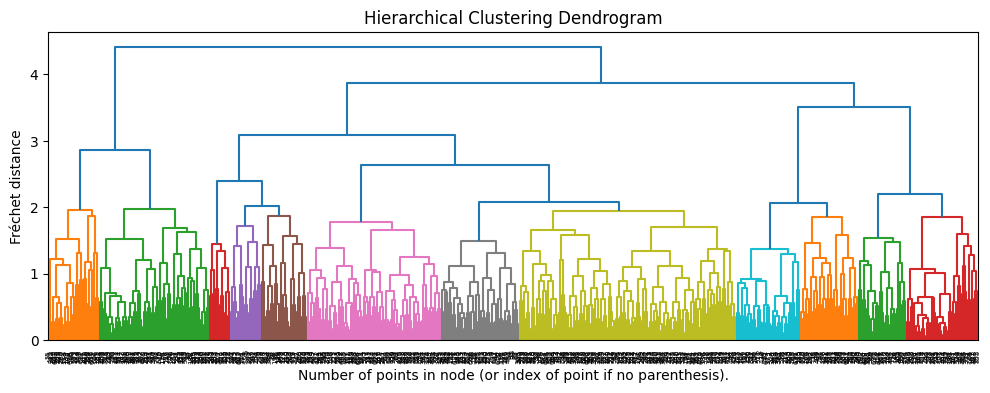

CPU times: user 2.27 s, sys: 141 ms, total: 2.41 s
Wall time: 2.3 s


In [18]:
%%time

# setting distance_threshold=0 ensures we compute the full tree.
ac = AgglomerativeClustering(metric='precomputed', linkage='complete', distance_threshold=0, n_clusters=None)
ac.fit(X=dm_pseudobulk_d37_dge_old_zscore)

plt.figure(figsize=(12,4))
plt.title('Hierarchical Clustering Dendrogram')
dend = plot_dendrogram(ac, truncate_mode=None, color_threshold=2, orientation='top')
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel('Fréchet distance')
plt.show()

Cluster 1
['Bsg' 'Smarcd2' 'Sertad1' 'Pfdn5' 'Atp1a1' 'Arpc1a' 'Stk11' 'Stk38'
 'Atp5k' 'Copz1' 'Rps10' 'Selenow' 'Pnpla2' 'Cd74' 'Prrc2a' 'U2af1'
 'Tsc22d3' 'Tmem259' 'Tkt' 'Lfng' 'Uqcr10' 'Ilkap' 'Snhg8' 'Itgal'
 'Laptm4a' 'Golph3' 'Snrpf' 'Nenf' 'Rnaset2a' 'Pfkfb4' 'Nfe2l2' 'Uqcr11'
 'Rnf187' '1810026B05Rik' 'Grk3' 'Drap1' 'Puf60' 'Hsd17b11' 'S100a13'
 'Ndufb2' 'Aqp1' 'Hnrnpl' 'Csnk1g2' 'Mrpl24' 'Ndufb5' 'Acox1' 'Thap3'
 'Chchd1' 'Med8' 'Fbxl3' 'U2af2' 'Rhob' 'Mrps16' 'Anapc4']
Cluster size = 54

Cluster 2
['Dync1h1' 'Ndufa2' 'Syf2' 'Atp5e' 'Rpl38' 'Rplp1' 'Ptms' 'Ptma' 'Cdk11b'
 'Rps24' 'Rbm47' 'Rbm25' 'Safb2' 'Cyb5r3' 'Prmt1' 'Ankrd11' 'Zc3h13'
 'Aamp' 'Anp32b' 'Gm26870' 'Wdr89' 'Hnrnpul2' 'Isoc2a' 'Hmgn5' 'Luc7l3'
 'Ppp4r2' 'Ppp4r1l-ps' 'Gripap1' 'Sort1' 'Htatsf1' 'Srek1' 'Gigyf2' 'Nes'
 'Akap12' 'Fam160b2' 'Taf15' 'A130071D04Rik' 'Akap8l' 'Cars' 'Trim44'
 'Supt6' 'Gm37376' 'Ddx23' 'Emc1' 'Chd7' 'Suds3' 'Dhx15' 'Utrn' 'Svil'
 'Erg' 'Cdc42bpb' 'Numa1' 'Fam133b' 'Zrsr2' 'Rc3h2' 'Ei

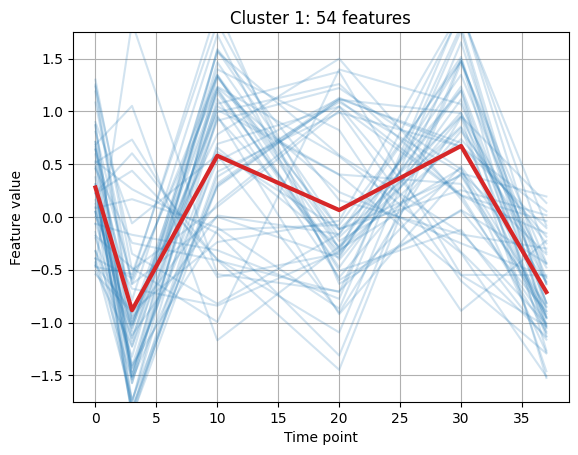

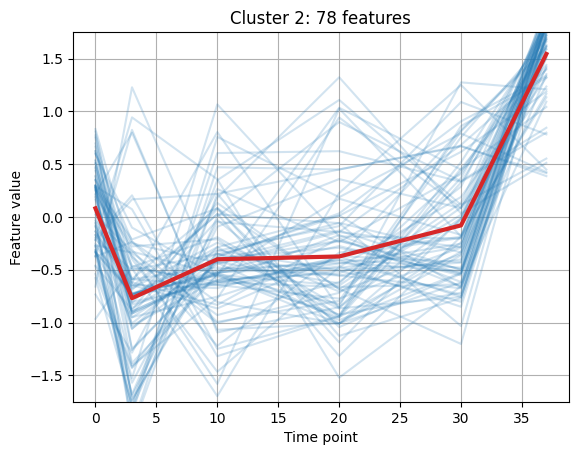

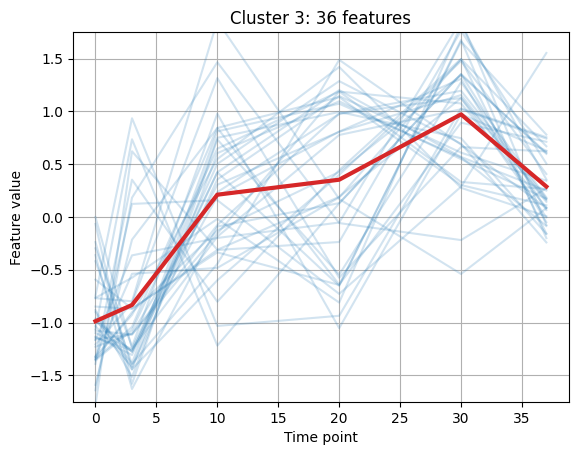

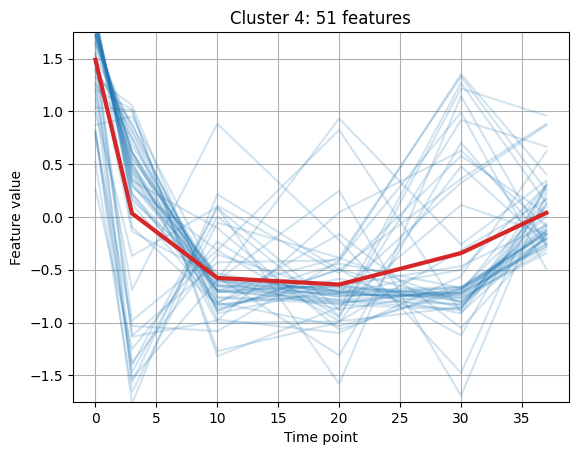

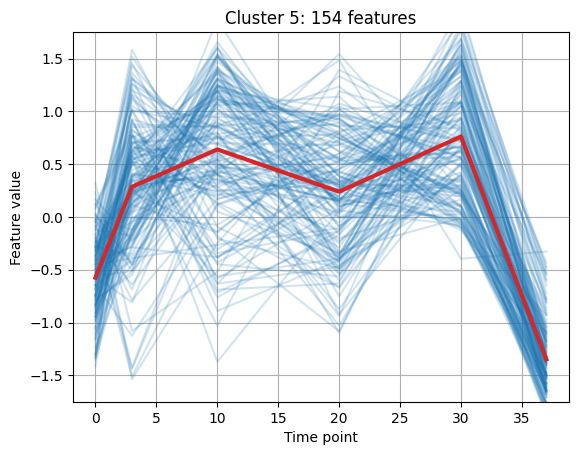

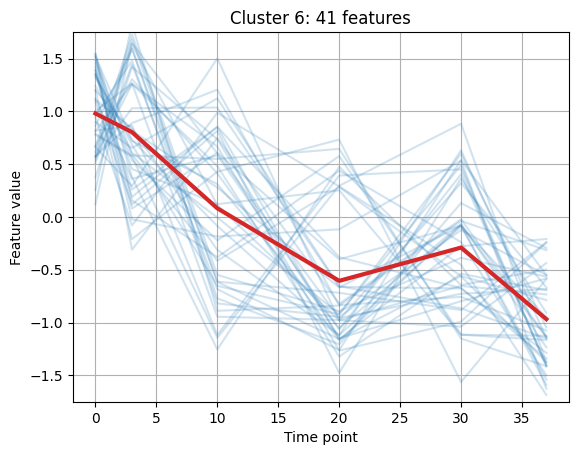

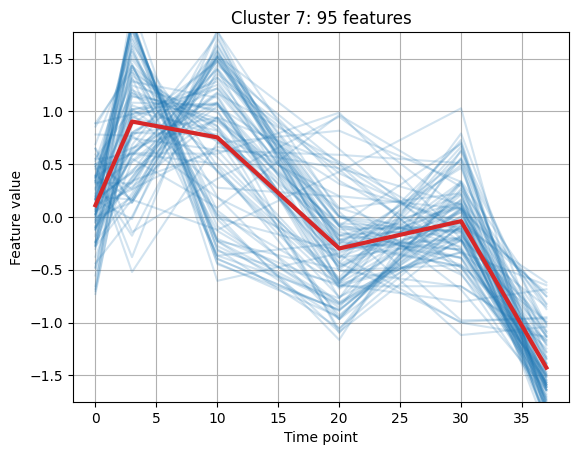

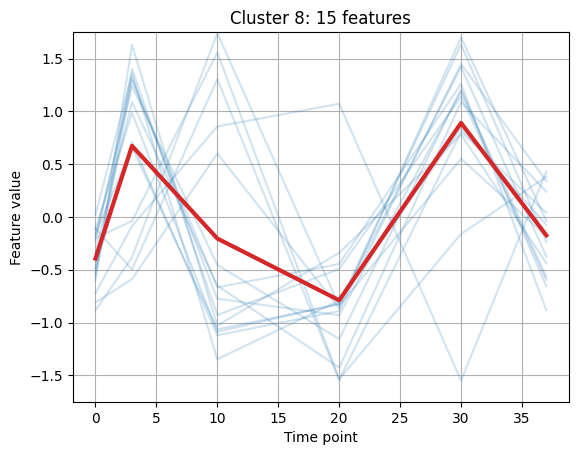

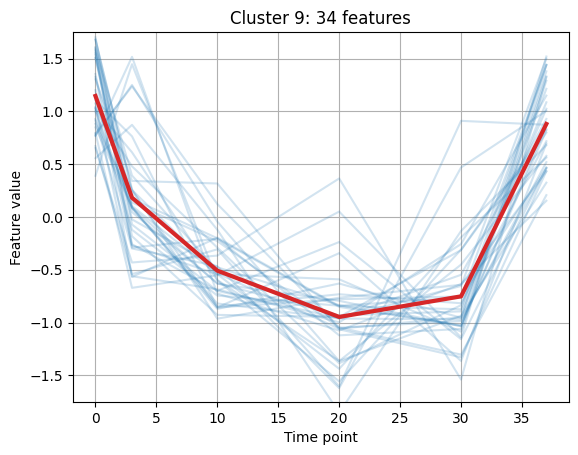

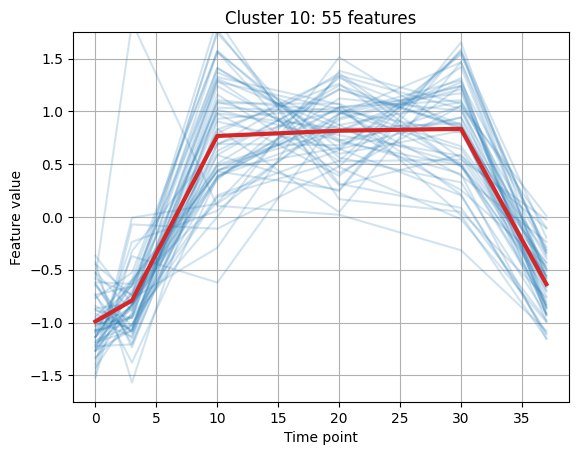

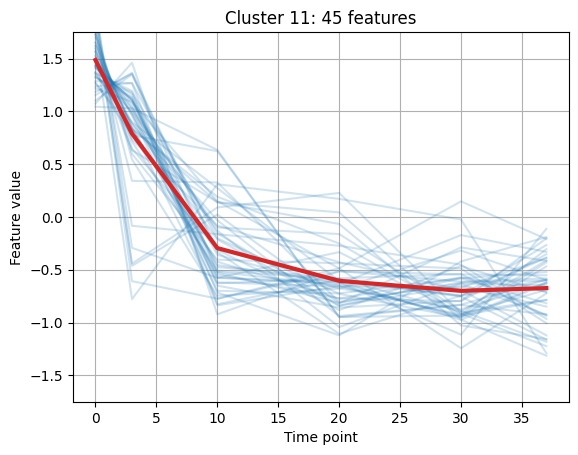

In [16]:
### Individual gene trajectories for old mice clusters 
frechet = dm_pseudobulk_d37_dge_old_zscore
expression = pseudobulk_d37_dge_old
logfc = "025"
age = "old"

n_clusters = 11
ac2 = AgglomerativeClustering(metric = 'precomputed', linkage = 'complete', n_clusters = n_clusters)
ac2.fit(X = frechet)
features_tab = pd.DataFrame()
for cluster in range(n_clusters):
    plt.figure()
    x_value = list()
    for feature in frechet.columns[ac2.labels_ == cluster]:
        x = expression[[feature]]
        x = (x-x.mean())/x.std()
        x_value.append(x)
        plt.plot(x.index, x.values, 'C0', alpha=0.2)
    x_value = pd.concat(x_value, axis=1).mean(axis=1)
    plt.plot(x_value.index, x_value.values, 'C3', alpha=1, linewidth=3)
    plt.ylim([-1.75, 1.75])
    plt.grid(True)
    #plt.xticks(x['timepoint'])
    #plt.xticks(x.index)
    plt.title('Cluster {}: {} features'.format(cluster +1, len(frechet.columns[ac2.labels_ == cluster])))
    plt.xlabel('Time point')
    plt.ylabel('Feature value')
    plt.savefig(f'/home/michaelammeter/projects/aging/dge_splines/output/plots_trajectories_dge_d37/cluster_{cluster +1}_qval_logfc{logfc}_ncluster{n_clusters}_{age}_mice_d37_dge_set_zscore_pseudobulk.pdf')
    plt.savefig(f'/home/michaelammeter/projects/aging/dge_splines/output/plots_trajectories_dge_d37/cluster_{cluster +1}_qval_logfc{logfc}_ncluster{n_clusters}_{age}_mice_d37_dge_set_zscore_pseudobulk.png')


for cluster in range(n_clusters):
    print('Cluster {}'.format(cluster + 1))
    features = frechet.columns[ac2.labels_ == cluster].values
    print(features)
    # indices = np.where(np.in1d(feature_names, features))[0]
    # print(feature_names_oryg[indices])
    print('Cluster size = {}'.format(len(features)))
    print('')
    with open(f'/home/michaelammeter/projects/aging/dge_splines/output/cluster_{cluster +1}_qval_logfc{logfc}_ncluster{n_clusters}_{age}_mice_d37_dge_set_zscore_pseudobulk.txt', 'w') as f:
        for gene in features:
            f.write(f"{gene}\n")

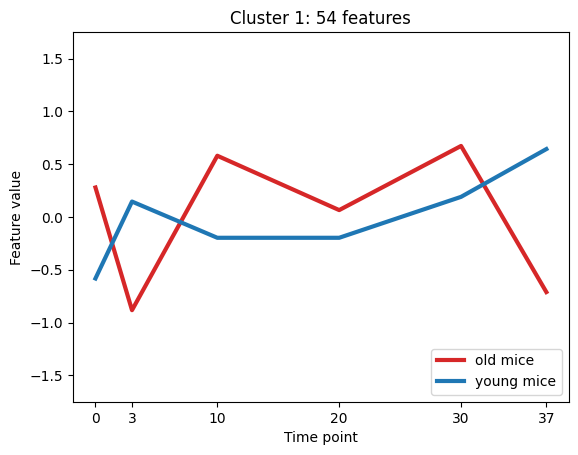

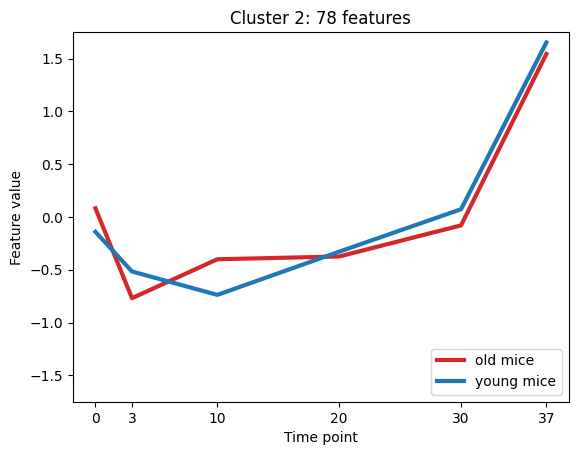

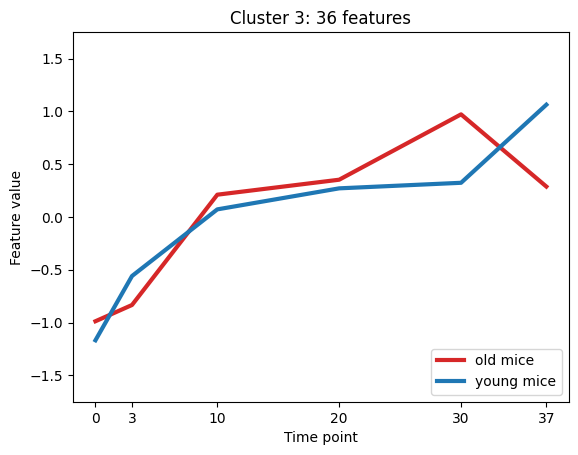

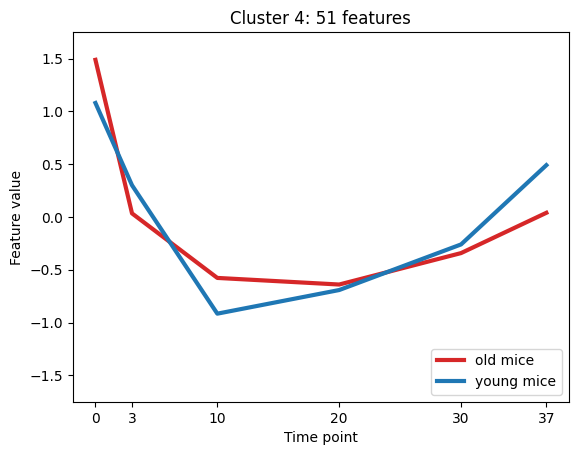

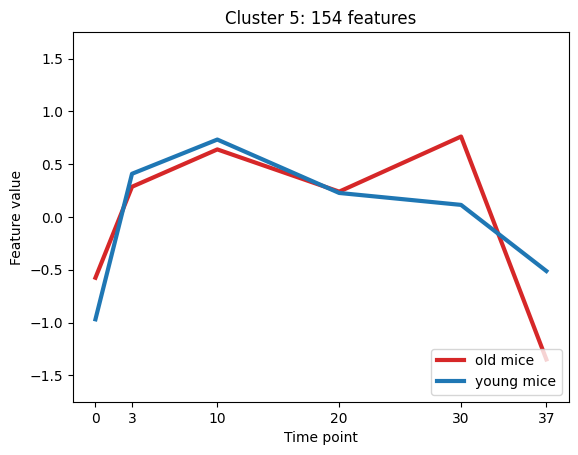

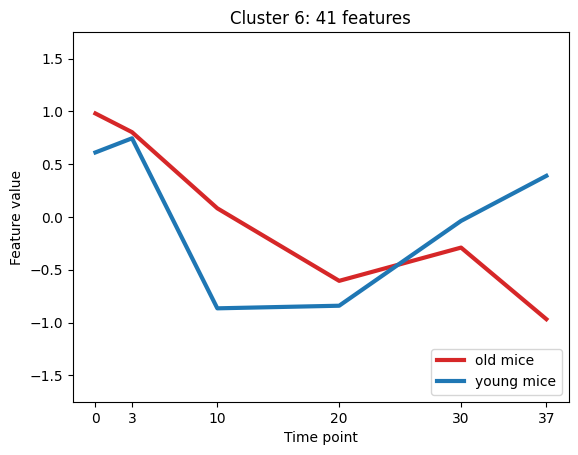

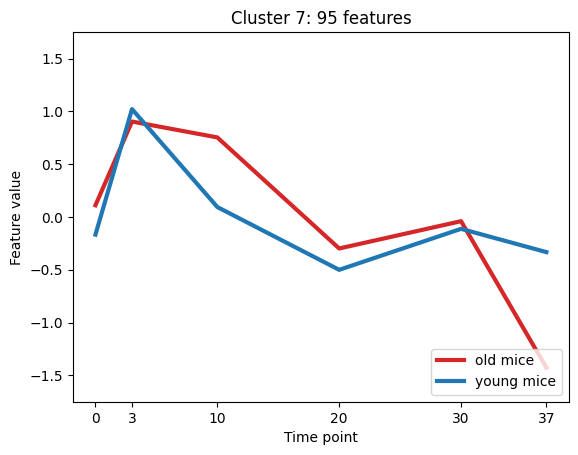

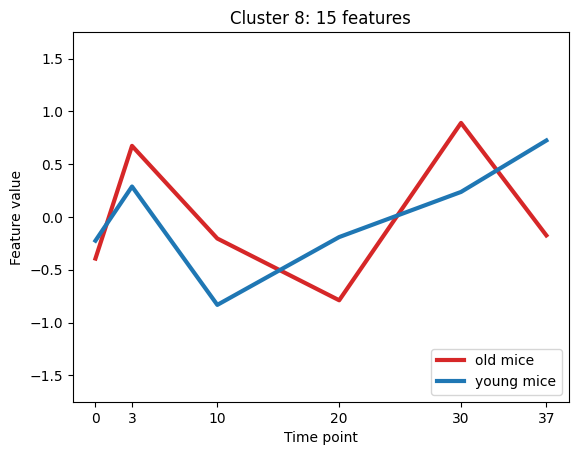

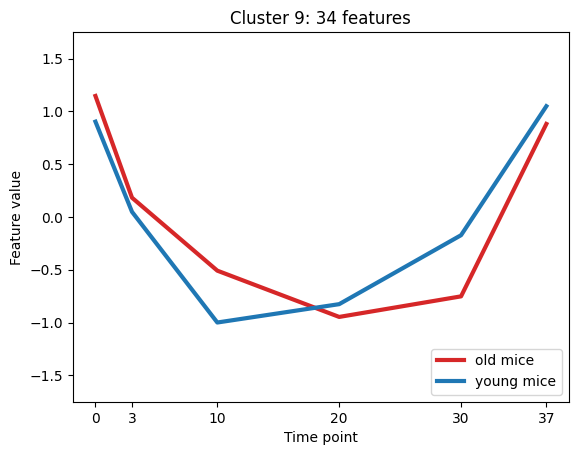

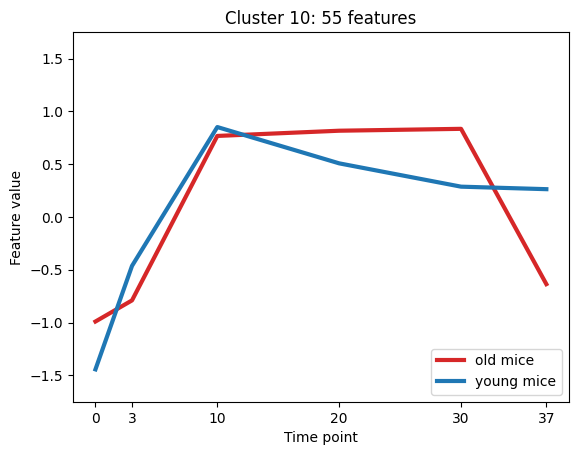

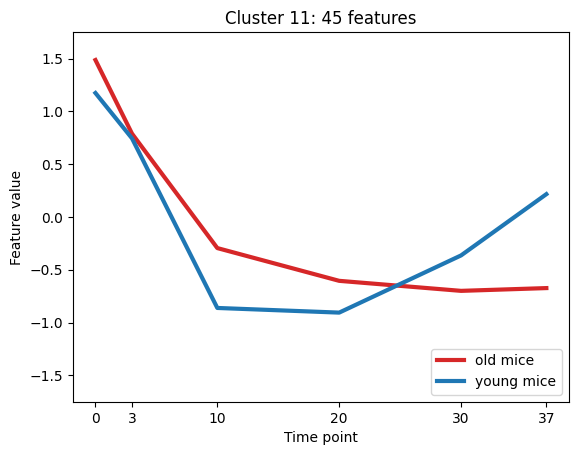

In [19]:
### Comparison of old vs. young mice
frechet = dm_pseudobulk_d37_dge_old_zscore
expression_young = pseudobulk_d37_dge_young
expression_old = pseudobulk_d37_dge_old
age = "old"

n_clusters = 11
logfc = "025"

ac2 = AgglomerativeClustering(metric = 'precomputed', linkage = 'complete', n_clusters = n_clusters)
ac2.fit(X = frechet)
for cluster in range(n_clusters):
    plt.figure()
    x_value_old = list()
    x_value_young = list()
    for feature in frechet.columns[ac2.labels_ == cluster]:
        # old mice
        x = expression_old[[feature]]
        x = (x-x.mean())/x.std()
        x_value_old.append(x)
        # young mice
        x = expression_young[[feature]]
        x = (x-x.mean())/x.std()
        x_value_young.append(x)

    x_value_old = pd.concat(x_value_old, axis=1).mean(axis=1)
    x_value_young = pd.concat(x_value_young, axis=1).mean(axis=1)

    plt.plot(x_value_old.index, x_value_old.values, 'C3', alpha = 1, linewidth = 3, label = 'old mice')
    plt.plot(x_value_young.index, x_value_young.values, 'C0', alpha = 1, linewidth = 3, label='young mice')

    plt.ylim([-1.75, 1.75])
    plt.grid(False)
    plt.xticks(x.index)
    plt.title('Cluster {}: {} features'.format(cluster +1, len(frechet.columns[ac2.labels_ == cluster])))
    plt.xlabel('Time point')
    plt.ylabel('Feature value')
    plt.legend(loc = 'lower right')

    plt.savefig(f'/home/michaelammeter/projects/aging/dge_splines/output/cluster_{cluster +1}_qval_logfc{logfc}_ncluster{n_clusters}_old_vs_young_{age}_mice_pseudo_d37_dge_set_zscore_pseudobulk.pdf')
    plt.savefig(f'/home/michaelammeter/projects/aging/dge_splines/output/cluster_{cluster +1}_qval_logfc{logfc}_ncluster{n_clusters}_old_vs_young_{age}_mice_pseudo_d37_dge_set_zscore_pseudobulk.png')
